# Módulo 10 tarefa 03
Considere a mesma base de dados utilizada na tarefa 1 ```previsao_de_renda.csv```.

1) Construa um gráfico de barras para avaliar a distribuição das variáveis qualitativas no tempo. Você acha que houve alguma alteração importante a ser investigada?

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) ler dados
df = pd.read_csv('previsao_de_renda.csv')

# 2) variáveis que vamos usar aqui (ex.: renda e log_renda)
df['log_renda'] = np.log(df['renda'].clip(lower=1))

# Parâmetros de tempo
n_meses = 3
n_clientes = 210

# Série de datas (um carimbo por cliente em cada mês)
datas = pd.date_range('2019-01-01', periods=n_meses, freq='MS').repeat(n_clientes)

# Amostra com reposição, índice sequencial
amostra = df.sample(n=n_meses * n_clientes, replace=True).reset_index(drop=True)

# Transformar a série de datas em DataFrame com NOME de coluna
datas_df = pd.Series(datas, name='data_ref').reset_index(drop=True)

# Concatenar lado a lado (índices 0..N-1 alinhados)
base_tempo = pd.concat([datas_df, amostra], axis=1)

base_tempo.head()


,data_ref,Unnamed: 0,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,mau,renda,log_renda
0,2019-01-01,12170,2016-01-01,3931,F,False,True,0,Pensionista,Secundário,Casado,Casa,63,NaN,2.0,False,9934.83,9.203802
1,2019-01-01,6740,2015-07-01,9293,M,False,False,0,Assalariado,Superior completo,Casado,Casa,36,8.600000,2.0,False,2266.51,7.725996
2,2019-01-01,4557,2015-05-01,690,F,False,True,0,Assalariado,Secundário,Casado,Casa,58,2.775342,2.0,False,3275.01,8.094076
3,2019-01-01,7893,2015-08-01,12795,F,True,True,2,Assalariado,Superior completo,Casado,Casa,31,5.282192,4.0,False,2287.25,7.735106
4,2019-01-01,14853,2016-03-01,5155,F,False,True,0,Pensionista,Superior completo,Casado,Casa,58,NaN,2.0,False,8228.37,9.015343


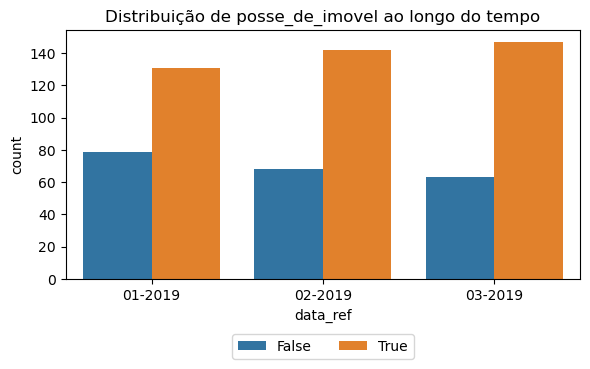

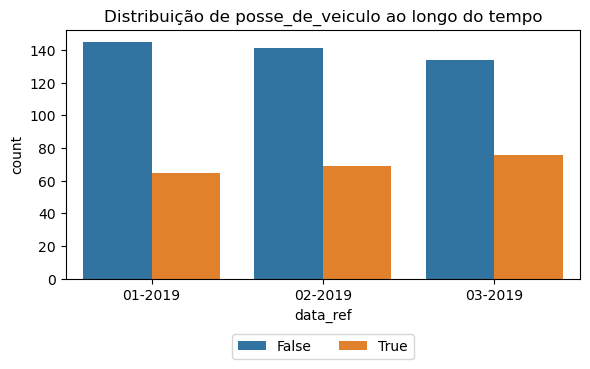

In [10]:
# --- 0) se 'data_ref' veio duplicada, mantenha só a primeira ---
if (base_tempo.columns == 'data_ref').sum() > 1:
    primeira = base_tempo.filter(regex=r'^data_ref$').iloc[:, 0]  # pega a 1ª coluna 'data_ref'
    base_tempo = base_tempo.drop(columns=['data_ref'])            # remove duplicadas
    base_tempo['data_ref'] = primeira

# --- 1) garantir datetime ---
base_tempo['data_ref'] = pd.to_datetime(base_tempo['data_ref'], errors='coerce')

# --- 2) ordem cronológica para o eixo X (Series única, sem duplicatas) ---
ordem = (base_tempo['data_ref']
         .dropna()
         .drop_duplicates()
         .sort_values())

# --- 3) fixar ordem categórica para o eixo X ---
base_tempo['data_ref'] = pd.Categorical(base_tempo['data_ref'],
                                        categories=ordem, ordered=True)

# --- 4) Gráfico: distribuição no tempo — posse_de_imovel ---
plt.figure(figsize=(6,4))
ax = sns.countplot(x='data_ref', hue='posse_de_imovel', data=base_tempo)
ax.set_xticks(range(len(ordem)))
ax.set_xticklabels(pd.Index(ordem).strftime('%m-%Y'), rotation=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
plt.title('Distribuição de posse_de_imovel ao longo do tempo')
plt.tight_layout(); plt.show()

# --- 5) Gráfico: distribuição no tempo — posse_de_veiculo ---
plt.figure(figsize=(6,4))
ax = sns.countplot(x='data_ref', hue='posse_de_veiculo', data=base_tempo)
ax.set_xticks(range(len(ordem)))
ax.set_xticklabels(pd.Index(ordem).strftime('%m-%Y'), rotation=0)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
plt.title('Distribuição de posse_de_veiculo ao longo do tempo')
plt.tight_layout(); plt.show()




As distribuições de posse_de_imovel e posse_de_veiculo se mantêm estáveis entre 01–2019 e 03–2019, com variações leves e sem mudanças estruturais.
Em todos os meses, posse_de_imovel = True predomina; já posse_de_veiculo = True é minoritário, com pequeno aumento ao longo do período.
Não há indício de drift relevante; portanto, ambas as variáveis podem ser usadas na modelagem.

2) Para cada variável qualitativa, construa um gráfico mostrando as médias de cada nível da variável no tempo e avalie a estabilidade. Houve alguma alteração importante? Você acha que se pode utilizar essas variáveis em uma modelagem?

In [23]:
# 1) Trabalhar numa cópia para evitar SettingWithCopyWarning
base_tempo = base_tempo.copy()

# 2) Garantir tipo datetime
base_tempo['data_ref'] = pd.to_datetime(base_tempo['data_ref'], errors='coerce')

# 3) Ordem cronológica p/ eixo X
ordem = (base_tempo['data_ref'].drop_duplicates().sort_values())

# 4) Rótulos (mm-aaaa)
tick_labels = ordem.dt.strftime('%m-%Y').tolist()

# 5) Coluna categórica ordenada
base_tempo['data_ref_cat'] = pd.Categorical(
    base_tempo['data_ref'],
    categories=ordem,
    ordered=True
)

# 6) log_renda (se não existir)
if 'log_renda' not in base_tempo.columns:
    base_tempo['log_renda'] = np.log(base_tempo['renda'].clip(lower=1))

# >>> MOSTRAR RESULTADO (amostra das colunas de tempo)
display(base_tempo[['data_ref','data_ref_cat','renda','log_renda']].head())

,data_ref,data_ref_cat,renda,log_renda
0,2019-01-01,2019-01-01,9395.37,9.147972
1,2019-01-01,2019-01-01,2117.39,7.657939
2,2019-01-01,2019-01-01,3144.81,8.053509
3,2019-01-01,2019-01-01,8563.14,9.055222
4,2019-01-01,2019-01-01,1976.44,7.589053


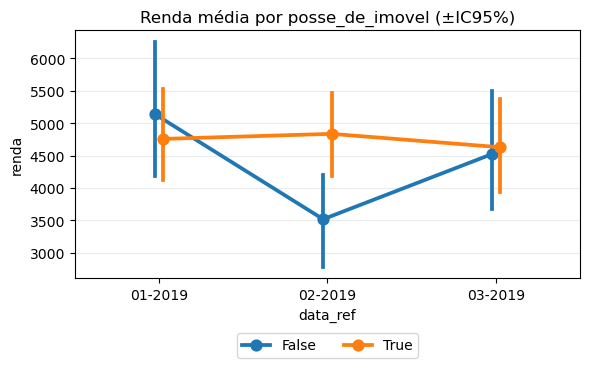

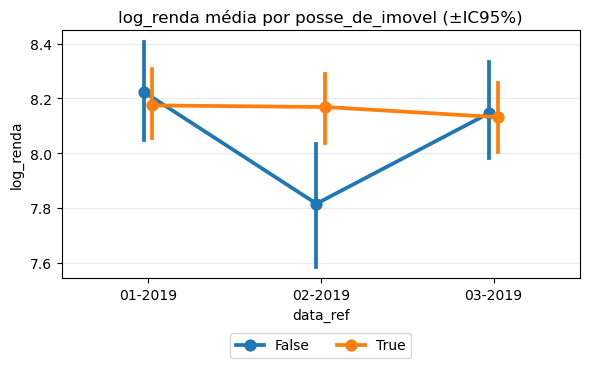

In [24]:
# Renda média por posse_de_imovel
plt.figure(figsize=(6,4))
ax = sns.pointplot(
    x='data_ref_cat', y='renda', hue='posse_de_imovel',
    data=base_tempo, dodge=True, errorbar=('ci', 95)
)
ax.set_xlabel('data_ref'); ax.set_ylabel('renda')
ax.set_xticks(range(len(ordem))); ax.set_xticklabels(tick_labels, rotation=0)
ax.grid(True, axis='y', alpha=0.25)
ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.35), ncol=3)
ax.set_title('Renda média por posse_de_imovel (±IC95%)')
plt.tight_layout(); plt.show()

# log_renda média por posse_de_imovel
plt.figure(figsize=(6,4))
ax = sns.pointplot(
    x='data_ref_cat', y='log_renda', hue='posse_de_imovel',
    data=base_tempo, dodge=True, errorbar=('ci', 95)
)
ax.set_xlabel('data_ref'); ax.set_ylabel('log_renda')
ax.set_xticks(range(len(ordem))); ax.set_xticklabels(tick_labels, rotation=0)
ax.grid(True, axis='y', alpha=0.25)
ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.35), ncol=3)
ax.set_title('log_renda média por posse_de_imovel (±IC95%)')
plt.tight_layout(); plt.show()



A renda média é consistentemente maior entre clientes com posse de imóvel ao longo dos três meses analisados. As médias se mantêm estáveis, com uma queda pontual em 02/2019 no grupo sem imóvel, sem indicar mudança estrutural. A transformação logarítmica preserva o padrão e reduz a variabilidade, reforçando a robustez do resultado. Conclui-se que posse_de_imovel é uma variável informativa e apropriada para uso como preditora de renda em modelos.

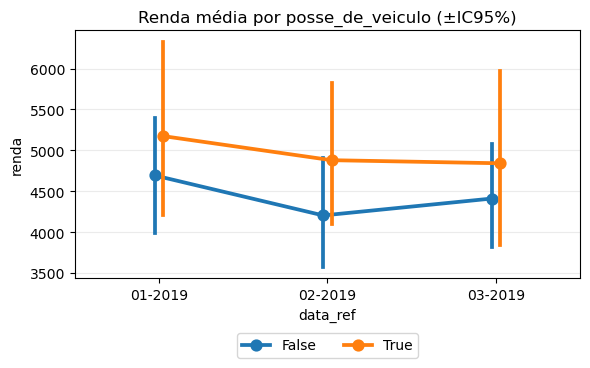

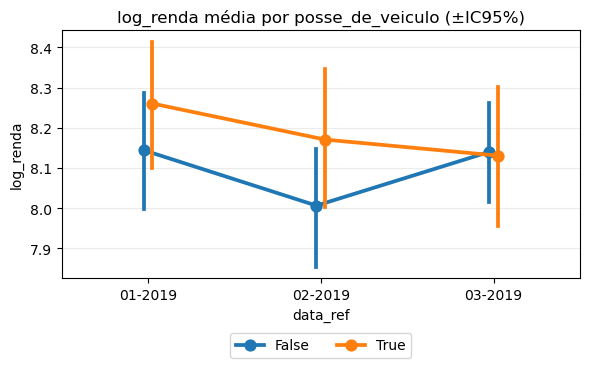

In [25]:
# Renda média por posse_de_veiculo
plt.figure(figsize=(6,4))
ax = sns.pointplot(
    x='data_ref_cat', y='renda', hue='posse_de_veiculo',
    data=base_tempo, dodge=True, errorbar=('ci', 95)
)
ax.set_xlabel('data_ref'); ax.set_ylabel('renda')
ax.set_xticks(range(len(ordem))); ax.set_xticklabels(tick_labels, rotation=0)
ax.grid(True, axis='y', alpha=0.25)
ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.35), ncol=3)
ax.set_title('Renda média por posse_de_veiculo (±IC95%)')
plt.tight_layout(); plt.show()

# log_renda média por posse_de_veiculo
plt.figure(figsize=(6,4))
ax = sns.pointplot(
    x='data_ref_cat', y='log_renda', hue='posse_de_veiculo',
    data=base_tempo, dodge=True, errorbar=('ci', 95)
)
ax.set_xlabel('data_ref'); ax.set_ylabel('log_renda')
ax.set_xticks(range(len(ordem))); ax.set_xticklabels(tick_labels, rotation=0)
ax.grid(True, axis='y', alpha=0.25)
ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.35), ncol=3)
ax.set_title('log_renda média por posse_de_veiculo (±IC95%)')
plt.tight_layout(); plt.show()


As médias de renda e log_renda por nível de posse_de_imovel e posse_de_veiculo permanecem estáveis entre 01/2019 e 03/2019, com variações leves. Em ambos os casos, o nível True apresenta médias consistentemente superiores ao False. Na escala log, o padrão se mantém com menor dispersão (ICs mais estreitos), indicando estabilidade e boa capacidade discriminativa. Portanto, ambas as variáveis qualitativas são adequadas para a modelagem, preferencialmente com a resposta em log_renda.